# Simple predictive modelling process: the solution

The previous activities could also have been written in one long statement, and it would still be easy to read:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

dataset = pd.read_csv('CS_Purchase_data.csv', index_col=0)
print(dataset.head())

# Remove unnecessary variables
to_remove = ['Product_Category_1','Product_Category_2', 'Product_Category_3', 'Product_ID']
purchase_data = dataset.drop(to_remove, axis=1)


# Group the purchases over the user
purchase_data = purchase_data.groupby( ['User_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status']).sum()
purchase_data = purchase_data.add_suffix('_Sum').reset_index()

print('After pre-processing:\n',purchase_data.head())

   User_ID Product_ID Gender   Age  Occupation City_Category  \
0  1000001  P00069042      F  0-17          10             A   
1  1000001  P00248942      F  0-17          10             A   
2  1000001  P00087842      F  0-17          10             A   
3  1000001  P00085442      F  0-17          10             A   
4  1000002  P00285442      M   55+          16             C   

  Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
0                          2               0                   3   
1                          2               0                   1   
2                          2               0                  12   
3                          2               0                  12   
4                         4+               0                   8   

   Product_Category_2  Product_Category_3  Purchase  
0                 NaN                 NaN      8370  
1                 6.0                14.0     15200  
2                 NaN                 NaN   

## Merging the datasets

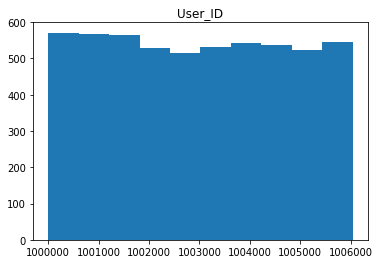

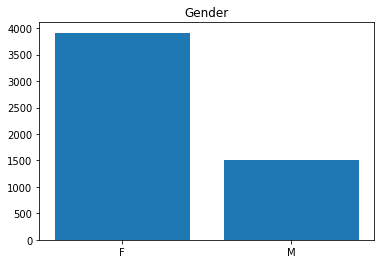

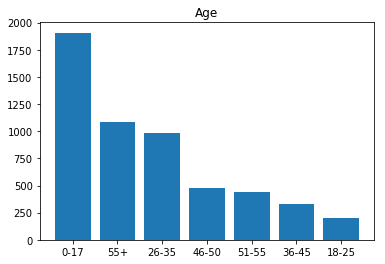

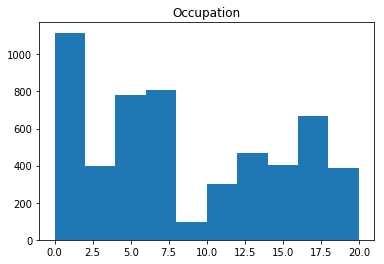

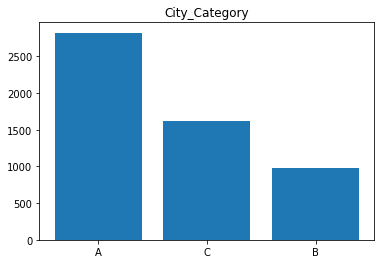

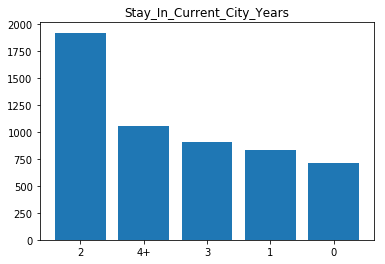

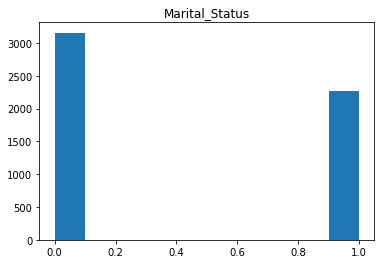

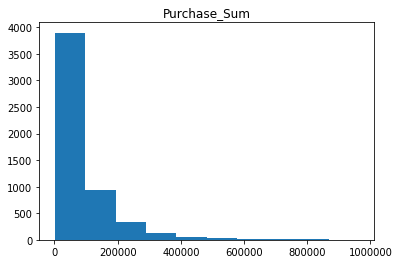

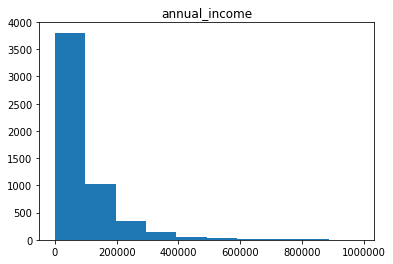

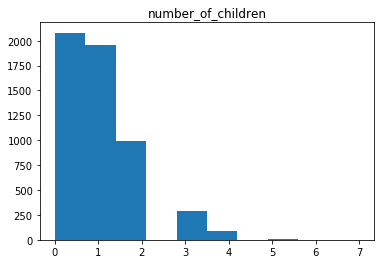

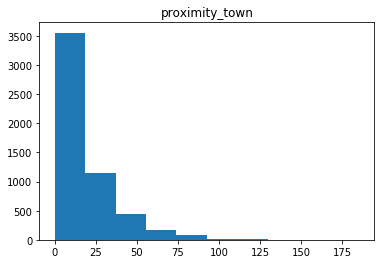

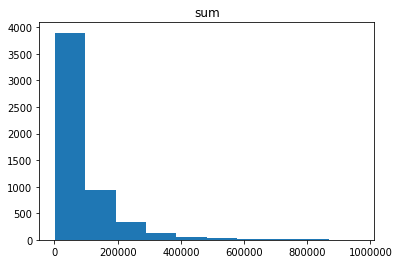

In [2]:
# Load the extra data
customer_data = pd.read_csv('CS_Customer_data.csv')

# Merge the datasets
final_data = purchase_data.copy()  
final_data = pd.merge(final_data, customer_data, on='User_ID', how='left')

# Take a look at your variables just now
for var in final_data.columns:
    if var in final_data.select_dtypes(include=['float64', 'float32', 'int64', 'int32']):
        plt.hist(final_data[var].fillna(0))
    else:
        plt.bar(x = final_data[var].unique(), height = final_data[var].value_counts())
    plt.title(var)
    plt.show()

In [3]:
# Drop the ID (or internalize it as the id instead of the current index)
fixed_id_data = final_data.drop(['User_ID'], axis=1)
print(final_data.head())

   User_ID Gender    Age  Occupation City_Category Stay_In_Current_City_Years  \
0  1000001      F   0-17          10             A                          2   
1  1000002      M    55+          16             C                         4+   
2  1000003      M  26-35          15             A                          3   
3  1000004      M  46-50           7             B                          2   
4  1000005      M  26-35          20             A                          1   

   Marital_Status  Purchase_Sum  annual_income  number_of_children  \
0               0         38891    42521.93013                   2   
1               0         37417    59199.36954                   0   
2               0         49947    40056.02938                   1   
3               1         66607    79474.66782                   0   
4               1         50684    85567.55715                   1   

   proximity_town    sum  
0        2.677101  38891  
1        3.589760  37417  
2        3.

## Transformation

In [4]:
# Transform categorical variables
transformed_data = fixed_id_data.copy()
to_transform = ['Age', 'Gender', 'City_Category', 'Stay_In_Current_City_Years']
for var in to_transform:
    transformed_data = pd.concat([transformed_data.drop(var, axis=1), pd.get_dummies(transformed_data[var].values, prefix=var, drop_first=True)], axis=1)

## Missing values

In [5]:
# Replace missing values with mean
mean = np.nanmean(transformed_data['proximity_town'])
transformed_data['proximity_town'] = transformed_data['proximity_town'].fillna(mean)

## Outliers

In [7]:
# Indicate outliers
marked_outliers = transformed_data.copy()
loc= LocalOutlierFactor(n_neighbors = 20, contamination = 0.1)
outliers_loc = loc.fit_predict(marked_outliers)
marked_outliers['outlier'] = pd.DataFrame(outliers_loc)

## Normalisation

In [8]:
# Standard normalise the appropriate variables
to_normalise = ['annual_income', 'proximity_town', 'Occupation', 'Purchase_Sum', 'number_of_children']  
normalised_data = marked_outliers.copy()
ss = StandardScaler()
norm_data = ss.fit_transform(normalised_data[to_normalise].values)
normalised_data[to_normalise] = norm_data

In [9]:
print(normalised_data.head())

   Occupation  Marital_Status  Purchase_Sum  annual_income  \
0    0.288734               0     -0.452944      -0.434067   
1    1.233680               0     -0.467259      -0.275620   
2    1.076189               0     -0.345577      -0.457494   
3   -0.183740               1     -0.183788      -0.082992   
4    1.863644               1     -0.338420      -0.025106   

   number_of_children  proximity_town    sum  Age_18-25  Age_26-35  Age_36-45  \
0            1.050259       -0.797397  38891          0          0          0   
1           -0.982428       -0.750248  37417          0          0          0   
2            0.033916       -0.731928  49947          0          1          0   
3           -0.982428       -0.796079  66607          0          0          0   
4            0.033916       -0.788903  50684          0          1          0   

    ...     Age_51-55  Age_55+  Gender_M  City_Category_B  City_Category_C  \
0   ...             0        0         0                0     

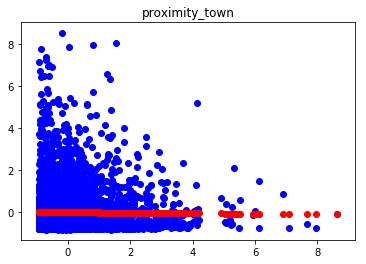

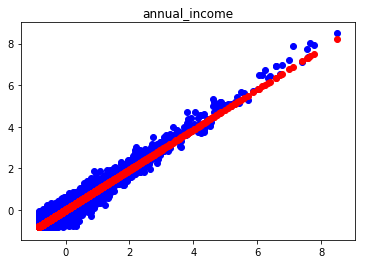

In [24]:
# Fit the model
lin_r = LinearRegression()
y = normalised_data['Purchase_Sum']

for variable in ['proximity_town', 'annual_income']:
    x = normalised_data[[variable]]

    lin_r.fit(x, y)
    predictions = lin_r.predict(x)

    plt.title(variable)
    plt.scatter(x, y, color = 'blue')
    plt.scatter(x, predictions, color = 'red')
    plt.show()